In [73]:
import os
import random

import numpy as np
import pandas as pd
import pdb

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = 'data'
annotation_csv = 'data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [153]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

### Dataset

In [208]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
transform = torchvision.transforms.ToTensor()
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )

def front_collate_fn(batch):
    front_imgs = []
    front_right_imgs = []
    front_left_imgs = []
    target = []
    road_imgs = []
    bbs = []
    for x in batch:
        # input
        front_left_imgs.append(torch.tensor(x[0][0]))
        front_imgs.append(torch.tensor(x[0][1]))
        front_right_imgs.append(torch.tensor(x[0][2]))
        road_imgs.append(torch.tensor(x[2]))
        
        # target
        bb_tens = x[1]['bounding_box']
        bbs.append(bb_tens)
        x_min = 800
        bb_cand = (-100, -100, 0)
        
        for i, corners in enumerate(bb_tens):
            # Get bird's eye view coordinates. 
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400
            if xs[2] - xs[0] > 5:
                top_center_x, top_center_y = 0.5*(xs[2] + xs[3]), 0.5*(ys[2] + ys[3])
            else:
                top_center_x, top_center_y = 0.5*(xs[0] + xs[1]), 0.5*(ys[0] + ys[1])
                
            v1 = np.array([top_center_x - 400, 800 - top_center_y - 400])
            v2 = np.array([2, 0])
            
            if abs(angle_between(v1, v2)) <= 35 and x[1]['category'][i] not in [1, 3, 6, 8]:
                if top_center_x < x_min:
                    x_min = top_center_x
                    bb_cand = (top_center_x.item(), top_center_y.item(), 1)
                
        target.append(bb_cand)
                    
    boom = torch.stack(front_imgs), torch.tensor(target), torch.stack(road_imgs), bbs, torch.stack(front_right_imgs), torch.stack(front_left_imgs)
    return boom

trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=5, shuffle=True, collate_fn=front_collate_fn)

In [238]:
sample, target, road_img, bbs, front_right, front_left = iter(trainloader).next()

/Users/vrajiv/anaconda3/envs/self_driving/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/vrajiv/anaconda3/envs/self_driving/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/vrajiv/anaconda3/envs/self_driving/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/vrajiv/anaconda3/envs/self_driving/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy constru

In [239]:
sample.shape

torch.Size([5, 3, 256, 306])

In [240]:
target

tensor([[ 727.0295,  429.2992,    1.0000],
        [ 526.2319,  430.8770,    1.0000],
        [ 505.5818,  431.5307,    1.0000],
        [-100.0000, -100.0000,    0.0000],
        [ 470.0107,  432.0921,    1.0000]])

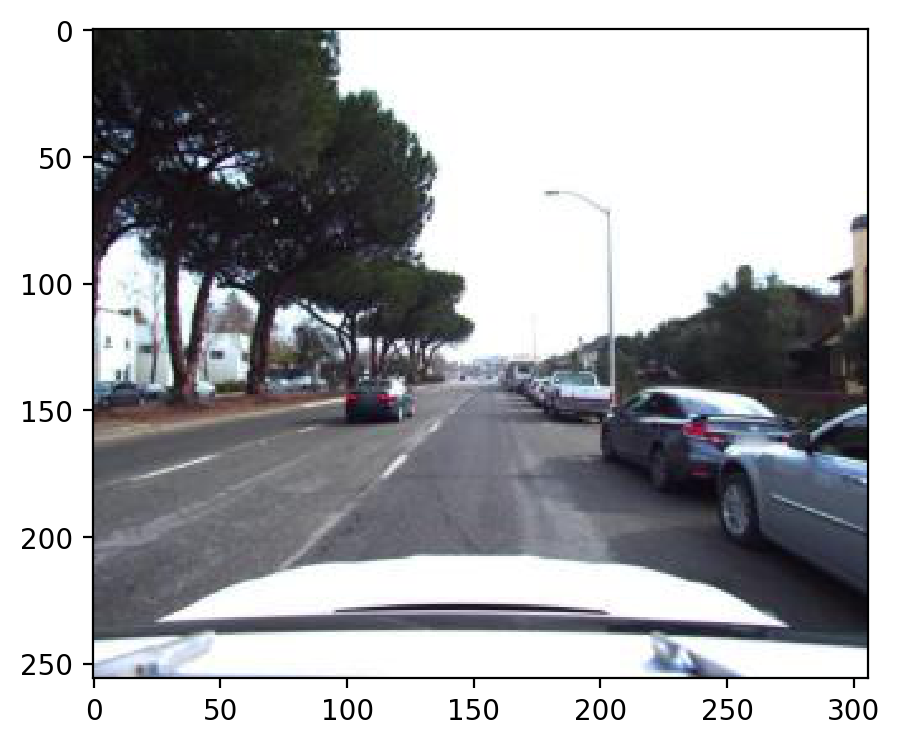

In [250]:
idx = 4
plt.imshow(sample[idx][:, :, :].numpy().transpose(1, 2, 0))
# plt.imshow(front_right[idx][:, :, :].numpy().transpose(1, 2, 0))

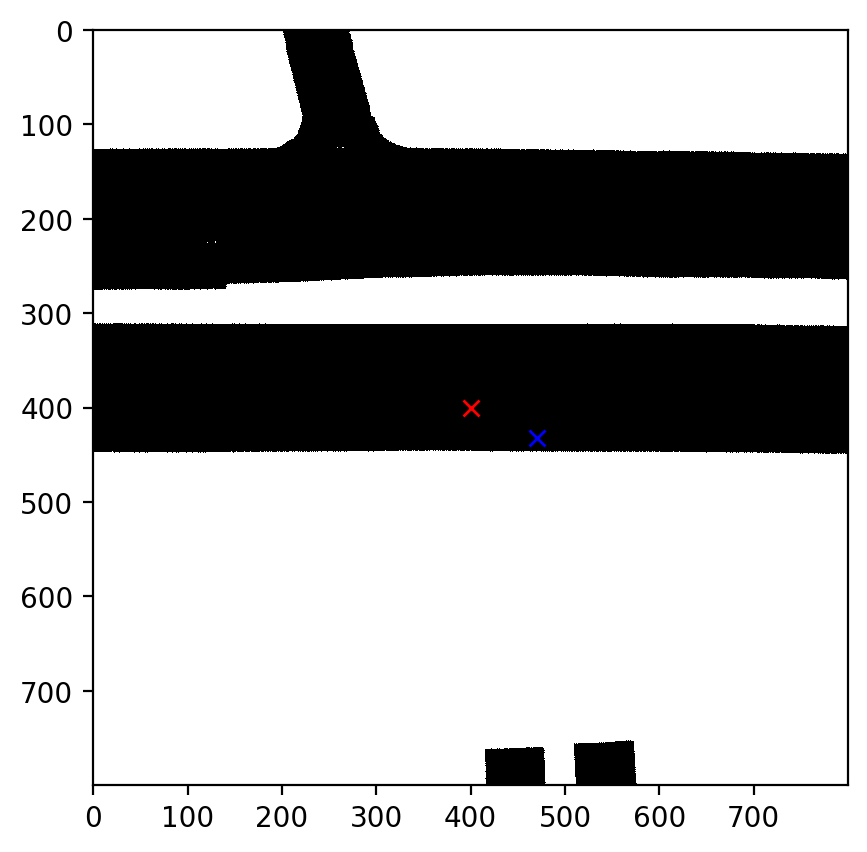

In [251]:
fig, ax = plt.subplots()
ax.imshow(road_img[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
ax.plot(target[idx][0], target[idx][1], 'x', color="blue")